# SOPHY Database
### Southern Ocean Phytoplankton Database
- Made by Ayush Nag and Hannah-Joy Warren (add others)
- UW Oceanography (add other credits)

In [1]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from pandas import DataFrame
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import numpy as np
import geolabel
import sophysql
import geopandas as gpd
import pyproj
from shapely.ops import transform
from matplotlib.colors import ListedColormap
import matplotlib.path as mpath

In [6]:
con = sqlite3.connect("sophy.db")
cur = con.cursor()

Query the SOPHY Database. Queries can be formatted using sophysql.query() params or sending SQL queries directly.

In [2]:
data = sophysql.query("select * from sample where source_name is null")
data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,29547,None,-62.7033,-69.6903,2014-10-31 00:00:00,None,None,9.8,10.104000,None,...,None,None,None,None,1.890,22.600,None,None,0.070000,None
1,29548,None,-62.7033,-69.6903,2014-10-31 00:00:00,None,None,3.5,3.751500,None,...,None,None,None,None,NaN,NaN,None,None,0.066667,None
2,29549,None,-62.7033,-69.6903,2014-10-31 00:00:00,None,None,76.3,77.533500,None,...,None,None,None,None,NaN,NaN,None,None,0.070000,None
3,29550,None,-62.7033,-69.6903,2014-10-31 00:00:00,None,None,24.7,24.887333,None,...,None,None,None,None,NaN,NaN,None,None,0.063333,None
4,29551,None,-62.7033,-69.6903,2014-10-31 00:00:00,None,None,100.1,101.419500,None,...,None,None,None,None,NaN,NaN,None,None,0.066667,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,29793,None,-65.8500,-71.3753,2014-11-21 00:00:00,None,None,9.9,10.098500,None,...,None,None,None,None,1.878,NaN,None,None,0.066667,None
247,29794,None,-65.8500,-71.3753,2014-11-21 00:00:00,None,None,99.2,100.208000,None,...,None,None,None,None,2.383,65.970,None,None,NaN,None
248,29795,None,-65.8500,-71.3753,2014-11-21 00:00:00,None,None,1.3,1.291000,None,...,None,None,None,None,1.853,44.440,None,None,0.070000,None
249,29796,None,-65.8500,-71.3753,2014-11-21 00:00:00,None,None,48.8,49.434167,None,...,None,None,None,None,2.058,51.825,None,None,NaN,None


In [5]:
# add other sample queries
# TODO: Make SQL Views for commonly used queries
# - filter by front and sector
# - filter by year range
# - view only a certain month over time
sophysql.query("select count(*) as entries, strftime('%Y-%m', timestamp) as year_month from occurrence group by year_month;")

,0,1
0,58,None
1,1,1824-07
2,1,1843-07
3,2,1844-07
4,1,1851-07
...,...,...
235,77,2012-04
236,15,2012-06
237,6,2012-07
238,8,2012-09


C:\Users\Ayush Nag\miniconda3\envs\sophyenv\lib\site-packages\geopandas\geodataframe.py:2352: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<GeoAxesSubplot:>

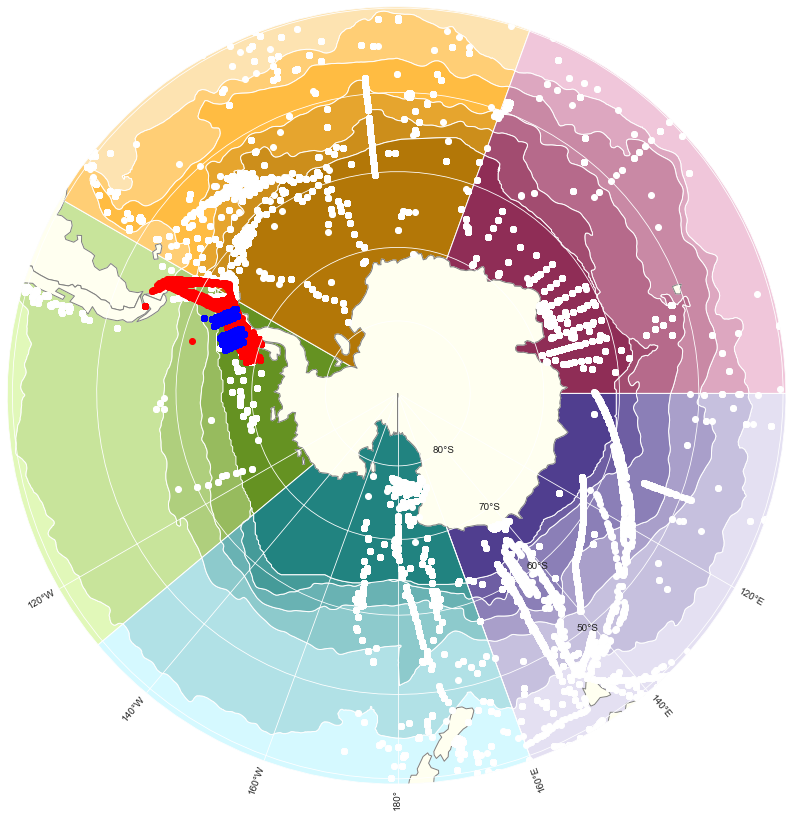

In [6]:
# Write some functions here that interact with sqlite and can plot the data
map_proj = ccrs.SouthPolarStereo()
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3031'), always_xy=True).transform
fig = plt.figure(figsize=[12, 12])  # inches
ax = plt.subplot(projection=map_proj)
# ax.set_facecolor('k')
ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

# ax.add_feature(cartopy.feature.LAND)
ax.gridlines(xlocs=[-160, -140, -120, 120, 140, 160, 180,], draw_labels=True)

def plot_circle_boundary() -> None:
    """
    Make SO plot boundary a circle.
    Compute a circle in axes coordinates, which we can use as a boundary for the map.
    We can pan/zoom as much as we like - the boundary will be permanently circular.
    """
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)

plot_circle_boundary()
# np.dstack((pie_lat, pie_lon))
s1 = transform(project, Polygon(zip(np.append(np.linspace(start=-130, stop=-60, num=1000), 0), np.append(np.full(1000, -30), -90))))
s2 = transform(project, Polygon(zip(np.append(np.linspace(start=-60, stop=20, num=1000), 0), np.append(np.full(1000, -30), -90))))
s3 = transform(project, Polygon(zip(np.append(np.linspace(start=20, stop=90, num=1000), 0), np.append(np.full(1000, -30), -90))))
s4 = transform(project, Polygon(zip(np.append(np.linspace(start=90, stop=160, num=1000), 0), np.append(np.full(1000, -30), -90))))
s5 = transform(project, Polygon(zip(np.append(np.append(np.linspace(start=160, stop=180, num=500), np.linspace(start=-180, stop=-130, num=500)), 0), np.append(np.full(1000, -30), -90))))
s: list = [s1, s2, s3, s4, s5]
sectors = gpd.GeoDataFrame(geometry=s, crs='EPSG:3031')
# xs, ys = p.exterior.xy
# ax.fill(xs, ys, alpha=0.1, fc='r', ec='none')

# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

# Color shades
greens  = ['#659222', '#7EA640', '#97BB5E', '#AFCF7D', '#C8E49B', '#E1F8B9']
yellows = ['#B37707', '#CC8E1B', '#E6A52E', '#FFBC42', '#FFCE75', '#FDE3B1']
maroons = ['#8F2D56', '#A24C70', '#B66A8B', '#C989A5', '#DDA7C0', '#F0C6DA']
purples = ['#503E8F', '#6E5EA3', '#8B7FB7', '#A99FCA', '#C6C0DE', '#E4E0F2']
teals   = ['#218380', '#459B99', '#69B2B3', '#8DCACC', '#B1E1E6', '#D5F9FF']

greens.reverse()
yellows.reverse()
maroons.reverse()
purples.reverse()
teals.reverse()


# List of all colors
color_palette = greens + yellows + maroons + purples + teals

# Make color palette
my_map = ListedColormap(sns.color_palette(color_palette).as_hex())

zones: gpd.GeoDataFrame = gpd.read_file(geolabel.zones_shapefile)
res = zones.overlay(sectors, how='intersection')

res.plot(ax=ax, cmap=my_map, edgecolor='w', legend=True)
world: gpd.GeoDataFrame = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.to_crs(epsg=3031).plot(ax=ax, color='ivory', edgecolor='grey')


sample_df: DataFrame = pd.read_csv('../data/datasets/modified/phytobase.csv', encoding='unicode_escape')
sample_df = sample_df[['latitude', 'longitude']]
sample_df['source'] = 'Palmer LTER'
data_gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.longitude, sample_df.latitude), crs='EPSG:4326')
data_gdf.to_crs(crs='EPSG:3031', inplace=True)
data_gdf.plot(ax=ax, color='w')


sample_df: DataFrame = pd.read_csv('../data/datasets/modified/lter.csv', encoding='unicode_escape')
sample_df = sample_df[['latitude', 'longitude']]
sample_df['source'] = 'Palmer LTER'
data_gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.longitude, sample_df.latitude), crs='EPSG:4326')
data_gdf.to_crs(crs='EPSG:3031', inplace=True)
data_gdf.plot(ax=ax, color='r')
# # ['SAZ', 'PFZ', 'ASZ', 'SOZ', 'SIZ']

sample_df: DataFrame = pd.read_csv('../data/datasets/modified/joy_warren.csv', encoding='unicode_escape')
sample_df = sample_df[['latitude', 'longitude']]
sample_df['source'] = 'Palmer LTER'
data_gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.longitude, sample_df.latitude), crs='EPSG:4326')
data_gdf.to_crs(crs='EPSG:3031', inplace=True)
data_gdf.plot(ax=ax, color='b')
# occ_df: DataFrame = pd.read_csv('../data/datasets/phytobase.csv', encoding='unicode_escape')
# occ_df = occ_df[['latitude', 'longitude']]
# occ_df = occ_df[occ_df['latitude'] < -30]
# occ_df['source'] = 'Phytobase'
# # data_gdf = gpd.GeoDataFrame(occ_df, geometry=gpd.points_from_xy(occ_df.longitude, occ_df.latitude), crs='EPSG:4326')
# # data_gdf.to_crs(crs='EPSG:9354').plot(ax=ax)

# alder_df: DataFrame = pd.read_csv('../data/datasets/alderkamp.csv', encoding='unicode_escape')
# alder_df = alder_df[['latitude', 'longitude']]
# alder_df['source'] = 'Alderkamp et al. 2019'

# full_palette = ['#F4D03F']
# full_colors = ListedColormap(sns.color_palette(full_palette).as_hex())
# full = sample_df.append([occ_df, alder_df], ignore_index=True)
# full_gdf = gpd.GeoDataFrame(full, geometry=gpd.points_from_xy(full.longitude, full.latitude), crs='EPSG:4326')
# full_gdf.to_crs(crs='EPSG:3031').plot(ax=ax, color='black')

In [ ]:
# color by type of data, data source, year, season
#   - option in plotting function
# update gridline labels to align with sectors
# red=chemtax, blue=micro, purple=both

# show by type of data available

# filter down area
# Two scatter plots for chemtax and microscopy vs. time
#   - sort by time to draw line
#   - try chemtax one first; test all chemtax, otherwise do phaeo, diatoms, other
# zoom to fit data (with padding for visibility)


# find a two way color scale with transparency for other (high alpha = high transparency)

In [3]:
data.to_csv({filepath})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
